#### Fitting to the average

Here, I fit the graph embeddings to also reflect the average pointing direction between nodes. For the distance, I use vector addition along the shortest path.

Are these embeddings better at predicting subject data, i.e., is there systematic bias in the data that is not captured by the basic assumptions of the fitting algorithm?

In [1]:
# Graph creation based on pixel position

import numpy as np
import networkx as nx 

# Pixel positions in "warren ground truth positions.png"
image_points = np.array([
    [133,909],[57,909],[61,779],[377,777],[403,669],
    [517,667],[553,511],[559,309],[663,245],[663,59],
    [785,59],[787,119],[53,59],[305,319],[185,313],
    [403,961],[183,1143],[100,1081],[481,1137],[579,1117],
    [705,521],[911,341],[1049,345],[1025,543],[1041,751],
    [919,931],[709,919],[653,723],[733,625],[879,637],
    [871,755],[1017,213],[1019,63],[897,61],[897,99],
    [1165,61],[1165,1165],[1005,1167],[861,1065],[847,1165],
    [781,1163],[595,607]
    ])

n = image_points.shape[0]

gt = image_points.astype(float)

offset = gt[0]
refLength = np.linalg.norm(gt[1]-gt[0])
gt = (gt-offset)/refLength*[1,-1] # Image coordinate to euclidean xy correction

# for exact measurements of wormhole1's entrance
wh1_entrances = np.array([[61,559],[557,57]],float)
wh1_entrances = (wh1_entrances-offset)/refLength*[1,-1] 

# 2 versions: Gn - no wormhole | Gw - wormhole
Gn = nx.Graph()
Gw = nx.Graph()
Gn.add_nodes_from(range(n))
Gw.add_nodes_from(range(n))

Gn.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,12),(9,12),(32,35),(35,36),(36,37)    # WH-related edges
    ])

Gw.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,9),(32,36),(36,37)  # WH-related edges
    ])


# exact distances
D = np.zeros((n,n))
for u,v in Gn.edges:
    D[u,v]=np.linalg.norm(gt[u]-gt[v])
    D[v,u]=np.linalg.norm(gt[u]-gt[v])
D[2,9] = D[9,2] = np.linalg.norm(gt[2]-wh1_entrances[0])\
    +np.linalg.norm(gt[9]-wh1_entrances[1])
D[32,36] = D[36,32] = D[32,35]

#triplets, exact angles
Tn = []
Tw = []
A = np.zeros((n, n, n),float)
for i in range(n):
    for j in range(n):
        for k in range(n):
            if Gn.has_edge(i,j) and Gn.has_edge(j,k):
                Tn.append([i,j,k])
                A[i,j,k] = np.math.atan2(np.linalg.det([gt[j]-gt[i], gt[j]-gt[k]]),
                    np.dot(gt[j]-gt[i], gt[j]-gt[k]))
            if Gw.has_edge(i,j) and Gw.has_edge(j,k):
                Tw.append([i,j,k])
Tn = np.asarray(Tn)
Tw = np.asarray(Tw)

# Wormhole angle changes
A[1,2,9] = A[1,2,12]
A[9,2,1] = A[12,2,1]
A[3,2,9] = A[3,2,12]
A[9,2,3] = A[12,2,3]
A[2,9,8] = A[12,9,8]
A[8,9,2] = A[8,9,12]
A[2,9,10] = A[12,9,10]
A[10,9,2] = A[10,9,12]

A[31,32,36] = A[31,32,35]
A[36,32,31] = A[35,32,31]
A[32,36,37] = A[35,36,37]
A[37,36,32] = A[37,36,35]
A[33,32,36] = A[33,32,35]
A[36,32,33] = A[35,32,33]

Gw.remove_node(12)
Gw.remove_node(35)

# Object positions
O = {
    "bookcase":0,
    "cactus":11,
    "clock":14,
    "earth":17,
    "flamingo":19,
    "gear":23,
    "moon":30,
    "well":34,
    "sink":40
}

In [2]:
# Overfitting the graph based on the average measurements in data_wh1:
import function_repository4 as fr4
import scipy.stats


def dataPerSubject1(data, s):
    """Importer function to extract a line from Warren's data"""

    dataPS = [
        [O["cactus"], O["bookcase"], data[s, 0]],
        [O["bookcase"], O["cactus"], data[s, 1]],
        [O["well"], O["sink"], data[s, 2]],
        [O["sink"], O["well"], data[s, 3]],
        [O["clock"], O["earth"], data[s, 4]],
        [O["earth"], O["clock"], data[s, 5]],
        [O["moon"], O["flamingo"], data[s, 6]],
        [O["flamingo"], O["moon"], data[s, 7]]
    ]

    for d in dataPS:
        # transform angular differences into global angles
        d[2] = np.deg2rad(d[2])+fr4.angle(gt[d[0]], gt[d[1]])

    return dataPS


# import subject data
data1 = np.loadtxt("datasets/data_wh1.txt",
                  delimiter='\t', skiprows=1, dtype=float)
# correction for mirrored angles due to warren dataset
data1[:, 0] *= -1
data1[:, 3:] *= -1

data_avg = scipy.stats.circmean(data1, -np.pi, np.pi, axis=0)
data_avg = dataPerSubject1(np.expand_dims(data_avg,axis=0), 0)

Go1 = Gw.copy()
To1 = Tw.copy()

for i in range(4):
    u = data_avg[2*i][0]
    v = data_avg[2*i][1]
    nbr_u = [nbr for nbr in Gw[u]][0]
    nbr_v = [nbr for nbr in Gw[v]][0]
    Go1.add_edge(u, v)
    path_uv = nx.dijkstra_path(Gw, u, v)
    v_uv = fr4.vectorAlongPath(path_uv, gt, D, A)
    D[u, v] = D[v, u] = np.linalg.norm(v_uv)
    A[nbr_u, u, v] = data_avg[2*i][2] - fr4.angle(gt[u], gt[nbr_u])
    A[nbr_v, v, u] = data_avg[2*i+1][2] - fr4.angle(gt[v], gt[nbr_v])
    To1 = np.append(To1, [[nbr_u, u, v]], axis=0)
    To1 = np.append(To1, [[nbr_v, v, u]], axis=0)


In [3]:
# Overfit graph based on rips&folds

def dataPerSubject2(data, headers, s):
    """Brings data in the form [o1, o2, angle]. Three rows correspond to one R&F."""
    dataPS = []
    for i in range(headers.shape[1]):
        start = headers[0, int(i/3)*3]
        target = headers[1, i]
        value = data[s, i]
        dataPS.append([start, target, value])

    # actual angles relative to 0°
    for d in dataPS:
        d[2] = np.deg2rad(d[2])+fr4.angle(gt[d[0]], gt[d[1]])

    return dataPS

# import subject data
data2 = np.loadtxt("datasets/data_rips.txt",delimiter='\t',skiprows=2,dtype=float)
headers = np.genfromtxt("datasets/data_rips_headers.txt", delimiter="\t",dtype=int)

# correction for mirrored angles due to warren dataset
data2[:,2:6]*=-1 
data2[:,9:12]*=-1
data2[:,14:18]*=-1
data2[:,21:]*=-1

data_avg = scipy.stats.circmean(data2, -np.pi, np.pi, axis=0)
data_avg = dataPerSubject2(np.expand_dims(data_avg,axis=0),headers, 0)

Go2 = Gw.copy()
To2 = Tw.copy()

for i in range(24): # over all measurements
    u = data_avg[i][0]
    v = data_avg[i][1]
    nbr_u = [nbr for nbr in Gw[u]][0]
    nbr_v = [nbr for nbr in Gw[v]][0]
    if not Go2.has_edge(u,v):
        Go2.add_edge(u, v)
        path_uv = nx.dijkstra_path(Gw, u, v)
        v_uv = fr4.vectorAlongPath(path_uv, gt, D, A)
        D[u, v] = D[v, u] = np.linalg.norm(v_uv)
    else:
        path_uv = nx.dijkstra_path(Gw, u, v)
        v_uv = fr4.vectorAlongPath(path_uv, gt, D, A)
        D[u, v] = D[v, u] = D[u,v]+np.linalg.norm(v_uv)/2
    A[nbr_u, u, v] = data_avg[i][2] - fr4.angle(gt[u], gt[nbr_u])
    To2 = np.append(To2, [[nbr_u, u, v]], axis=0)


In [4]:
# Find embeddings based on a fixed random seed, as in the other files.
import scipy.optimize

# Node 0 is constrained to (0,0)
cons = ({'type': 'eq', 'fun': lambda x: x[0]},
        {'type': 'eq', 'fun': lambda x: x[1]})

np.random.seed(3773)
x0 = np.random.uniform(size=(n, 2))
sl1 = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, D, A, To1),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Overfit Sc embedding - Iterations: {}, stress: {}".format(sl1.nit, sl1.fun))
emo1 = sl1.x.reshape(n, 2)

np.random.seed(3773)
x0 = np.random.uniform(size=(n, 2))
slo = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, D, A, To2),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Overfit rnf - Iterations: {}, stress: {}".format(slo.nit, slo.fun))
emo2 = slo.x.reshape(n, 2)

Overfit Sc embedding - Iterations: 127, stress: 531.3100558448119
Overfit rnf - Iterations: 135, stress: 827.5580654921035


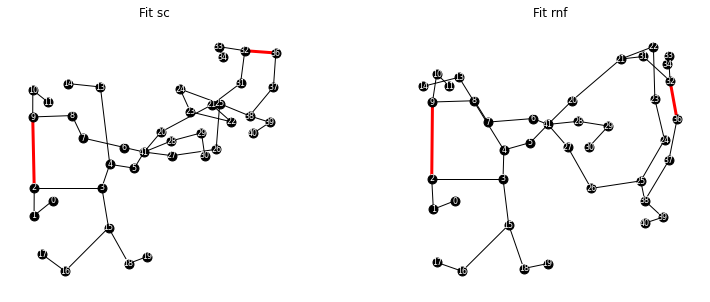

In [6]:
# [Run twice for large plots!] Rotate and plot the embeddings
import matplotlib.pyplot as plt
import matplotlib.patches

plt.rcParams['figure.figsize'] = [13, 5]

r1 = fr4.angle(emo1[2], emo1[3])
emo1 = emo1@np.array([[np.cos(r1), -np.sin(r1)], [np.sin(r1), np.cos(r1)]])

r2 = fr4.angle(emo2[2], emo2[3])
emo2 = emo2@np.array([[np.cos(r2), -np.sin(r2)], [np.sin(r2), np.cos(r2)]])


ax = plt.subplot(121, aspect='equal')
plt.plot([emo1[2][0], emo1[9][0]], [emo1[2][1],
         emo1[9][1]], color='r', linewidth=3)
plt.plot([emo1[32][0], emo1[36][0]], [emo1[32][1],
         emo1[36][1]], color='r', linewidth=3)
nx.draw(Gw, with_labels=True, node_size=80, pos=emo1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Fit sc")


ax = plt.subplot(122, aspect='equal')
plt.plot([emo2[2][0], emo2[9][0]], [emo2[2][1],
         emo2[9][1]], color='r', linewidth=3)
plt.plot([emo2[32][0], emo2[36][0]], [emo2[32][1],
         emo2[36][1]], color='r', linewidth=3)
nx.draw(Gw, with_labels=True, node_size=80, pos=emo2, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Fit rnf")

plt.show()


In [7]:
# Generate data SC

def angularError(m, vec, ed=1):
    """
    Maybe the error that was used by Warren 2017. Who knows?
    ed = 1/-1 is the direction in which the error increases, as in Warren2017
    """
    a = m[2]
    b = np.arctan2(vec[1], vec[0])
    smaller_angle = (a-b+np.pi) % (2*np.pi)-np.pi
    return ed*smaller_angle

leftRightIncrease = [-1, 1, 1, -1, -1, -1, -1, -1]

dataset_ae_o1 = []

for s in range(len(data1)):
    data_sub = dataPerSubject1(data1, s)
    est_local = fr4.makeLocal(Gw, gt, emo1, data_sub)

    ae_emo1 = []
    for ed, m in zip(leftRightIncrease, est_local):
        v = emo1[m[1]]-emo1[m[0]]
        ae_emo1.append(angularError(m, v, ed))


    dataset_ae_o1.append(ae_emo1)

dataset_ae_o1 = np.asarray(dataset_ae_o1)
print("Dataset_ae shape: {}".format(dataset_ae_o1.shape))


Dataset_ae shape: (10, 8)


In [8]:
# Generate data RnF

leftRightIncrease = [1, 1, -1,   -1, -1, -1,   1, 1, 1,   -1, -1, -1, 
                     1, 1, -1,   -1, -1, -1,   1, 1, 1,   -1, -1, -1]

dataset_ae_o2 = []

for s in range(len(data2)):
    data_sub = dataPerSubject2(data2, headers, s)
    est_local = fr4.makeLocal(Gw, gt, emo2, data_sub)

    ae_emo2 = []
    for ed, m in zip(leftRightIncrease, est_local):
        v = emo2[m[1]]-emo2[m[0]]
        ae_emo2.append(angularError(m, v, ed))


    dataset_ae_o2.append(ae_emo2)

dataset_ae_o2 = np.asarray(dataset_ae_o2)
print("Dataset_ae shape: {}".format(dataset_ae_o2.shape))

Dataset_ae shape: (11, 24)


Results, overall average:
Avg. angular error: va1: -18.0320° | emo1: 7.4110°
Overall angular deviation va1:12.1174°, emo1:11.8929°
Avg. angular error: va2: 5.6838° | emo2: 11.7424°
Overall angular deviation va2:8.1192°, emo2:9.1600°


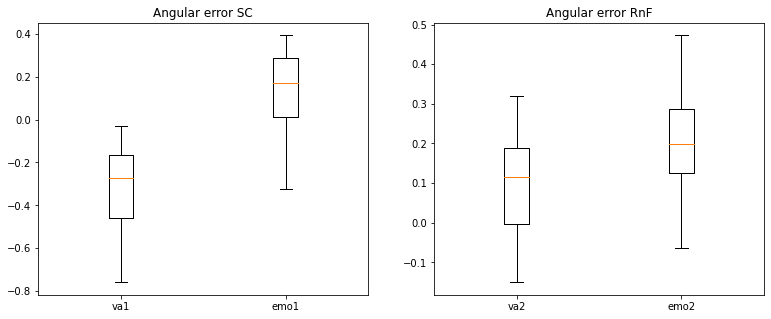

In [9]:
dataset_va1 = np.loadtxt("datasets/dataset_ae.txt", delimiter="\t", dtype=float)
dataset_va2 = np.loadtxt("datasets/dataset_RnF_ae3.txt", delimiter="\t", dtype=float)

ae_va1 = scipy.stats.circmean(dataset_va1[:, :24], np.pi, -np.pi, axis=1)
ae_emo1 = scipy.stats.circmean(dataset_ae_o1, np.pi, -np.pi, axis=1)

ae_va2 = scipy.stats.circmean(dataset_va2[:, :24], np.pi, -np.pi, axis=1)
ae_emo2 = scipy.stats.circmean(dataset_ae_o2, np.pi, -np.pi, axis=1)

print("Results, overall average:")

print("Avg. angular error: va1: {:.4f}° | emo1: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean((ae_va1), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean((ae_emo1), np.pi, -np.pi))))

print("Overall angular deviation va1:{:.4f}°, emo1:{:.4f}°".format(
    np.rad2deg(scipy.stats.circstd(ae_va1, np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circstd(ae_emo1, np.pi, -np.pi))))


print("Avg. angular error: va2: {:.4f}° | emo2: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean((ae_va2), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean((ae_emo2), np.pi, -np.pi))))

print("Overall angular deviation va2:{:.4f}°, emo2:{:.4f}°".format(
    np.rad2deg(scipy.stats.circstd(ae_va2, np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circstd(ae_emo2, np.pi, -np.pi))))


# Boxplot of the results
ax = plt.subplot(121)
ax.boxplot([ae_va1, ae_emo1])
ax.set_xticklabels(["va1", "emo1"])
ax.set_title("Angular error SC")

ax = plt.subplot(122)
ax.boxplot([ae_va2, ae_emo2])
ax.set_xticklabels(["va2", "emo2"])
ax.set_title("Angular error RnF")
plt.show()
